In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt

np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# load data

path_to_folder = '/content/drive/MyDrive/Colab Notebooks/kaggle/mnist/'

train_data = pd.read_csv(path_to_folder + 'train.csv')
test_data = pd.read_csv(path_to_folder + 'test.csv')

In [ ]:
# normalize values

Y_whole = train_data['label'].values
X_whole = train_data.drop('label', axis=1).values / 255.
X_test = test_data.values / 255.


# reshape data

X_whole = X_whole.reshape((-1, 28, 28, 1))
X_test = X_test.reshape((-1, 28, 28, 1))

In [ ]:
K = keras.backend

# create methods to find optimal learning rates

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = len(X) // batch_size * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

In [ ]:
# implementation of 1cycle learning policy

class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
            rate = max(rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)

In [ ]:
# data generator

from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_generator = ImageDataGenerator(rotation_range=10,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.1,
                               zoom_range=0.1,
                               horizontal_flip=False,
                               vertical_flip=False
                              )

In [ ]:
# model definition

models = []

model = keras.models.Sequential()

model.add(keras.layers.Input((28, 28, 1)))


model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Conv2D(filters=32, kernel_size=5, padding='same', activation='selu'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Conv2D(filters=32, kernel_size=5, padding='same', activation='selu'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.MaxPool2D())

model.add(keras.layers.Conv2D(filters=64, kernel_size=5, padding='same', activation='selu'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Conv2D(filters=64, kernel_size=5, padding='same', activation='selu'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.MaxPool2D())

model.add(keras.layers.Conv2D(filters=128, kernel_size=5, padding='same', activation='selu'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.MaxPool2D())

model.add(keras.layers.Flatten())
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(512, activation='selu'))

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(32, activation='selu'))

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(10, activation='softmax'))

models.append(model)

1313/1313 [==============================] - 29s 22ms/step - loss: 854.0471 - accuracy: 0.7110


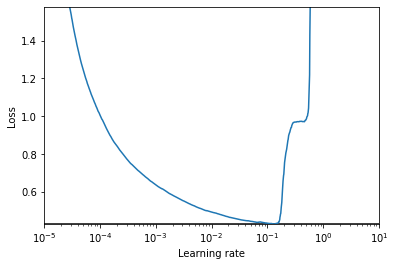

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)


def model_preparation(model):
  custom_optimizer = keras.optimizers.Nadam()

  model.compile(optimizer=custom_optimizer,
                loss=keras.losses.sparse_categorical_crossentropy,
                metrics=['accuracy'])

for model in models:
  model_preparation(model)

batch_size = 32
rates, losses = find_learning_rate(models[0], X_whole, Y_whole, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

# split train to get validation set


#from sklearn.model_selection import train_test_split
#X_train, X_val, Y_train, Y_val = train_test_split(X_whole, Y_whole, test_size=.1, random_state=42)


# for fine tuning using all the data available
X_train = X_whole
Y_train = Y_whole

# compile, train then optimize the model

max_rate = .003

def model_preparation(model):
  custom_optimizer = keras.optimizers.Nadam()

  model.compile(optimizer=custom_optimizer,
                loss=keras.losses.sparse_categorical_crossentropy,
                metrics=['accuracy'])
  
for model in models:
  model_preparation(model)

training_histories = []

n_epochs = 100
batch_size = 32

onecycle = OneCycleScheduler(len(X_train) // batch_size * n_epochs, max_rate=max_rate, start_rate=max_rate/100)

history = models[0].fit(image_generator.flow(X_train, Y_train, batch_size=batch_size), epochs=n_epochs,
                                  validation_data=(X_val, Y_val),
                                  callbacks=[
                                            onecycle, 
                                            #keras.callbacks.EarlyStopping('val_loss', patience=5, restore_best_weights=True)
                                            keras.callbacks.EarlyStopping('loss', patience=2, restore_best_weights=True)
                                            ], verbose=1)

Epoch 1/4
1313/1313 [==============================] - 37s 28ms/step - loss: 0.0220 - accuracy: 0.9934 - val_loss: 0.0134 - val_accuracy: 0.9952
Epoch 2/4
1313/1313 [==============================] - 34s 26ms/step - loss: 0.0212 - accuracy: 0.9933 - val_loss: 0.0124 - val_accuracy: 0.9962
Epoch 3/4
1313/1313 [==============================] - 34s 26ms/step - loss: 0.0170 - accuracy: 0.9949 - val_loss: 0.0116 - val_accuracy: 0.9967
Epoch 4/4
1313/1313 [==============================] - 34s 26ms/step - loss: 0.0150 - accuracy: 0.9952 - val_loss: 0.0102 - val_accuracy: 0.9967


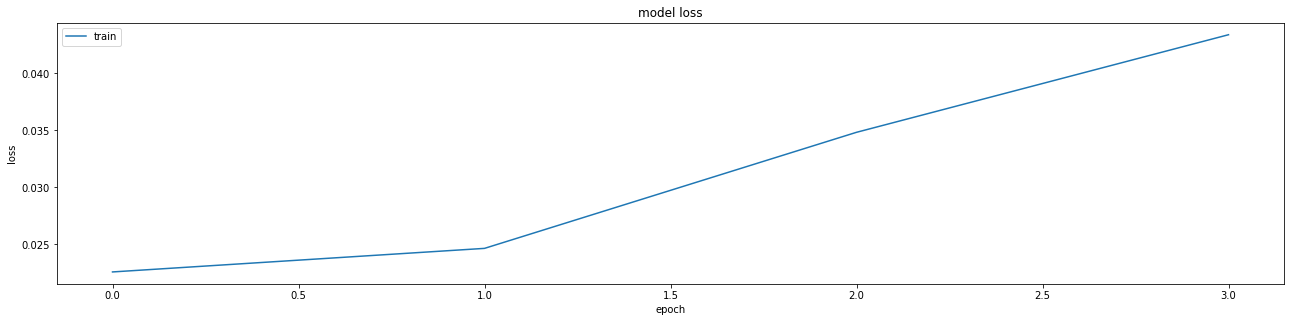

In [ ]:
def plot_history_by_label(training_history, label):
  val_label = 'val_' + label

  plt.figure(figsize=[22., 4.8])
  plt.plot(training_history.history[label])
  if val_label in training_history.history:
    plt.plot(training_history.history[val_label])
  plt.title('model ' + label)
  plt.ylabel(label)
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()


training_histories.append(history)

for history in training_histories:
  plot_history_by_label(history, 'loss')

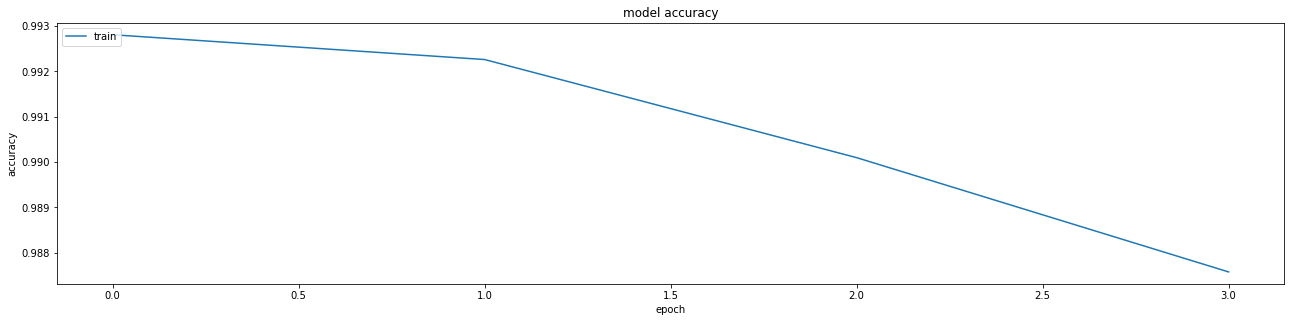

In [ ]:
for history in training_histories:
  plot_history_by_label(history, 'accuracy')

In [ ]:
# create predictions according to specification for submission

predictions = models[0].predict(X_test).argmax(1)

start_index = 1
predictions = np.c_[np.arange(start_index, start_index + len(X_test)), predictions]

In [ ]:
# save predictions to csv

np.savetxt('/content/predictions.csv', predictions, header='ImageId,Label', comments='', fmt='%d,%d')